In [2]:
import torch
import os
import sys
sys.path.insert(0, '../src')

from transformers import DonutProcessor
from modeling_tabeleiro import TabeleiroModel
from processing_tabeleiro import TabeleiroProcessor
from PIL import Image


IMG_PATH = "../../aux/data/imgs/final_eval/"

filelist = os.listdir(IMG_PATH)

/home/jao/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
filelist[:10]

['8621fa63b29c02efea427bdb210e3d896a8ba07299052095ee6eb94d2218aca5.png',
 'cb8ce80fc6149d3c9af03f52f0bb3075778b8a28e18324e6bfee084838b8cb02.png',
 'f3b0b3c68db9f71dbc32f53f26a79d839410bb1260a75a685d843d45e45e1781.png',
 '63eff125664ac9e982bbda705cde8c6ce1cdbd9a799e5fca97fe917be81d84dd.png',
 '69b44706b64364cca8e5045717597e1f68c23e1fc283c89bec879bfa2acec7c2.png',
 '11cd20efc60a947c217c9916e28dd05102c2ba05cf78b545e49b1bf117b347c6.png',
 'ef4c7af62ccd6d6834e04a4ac6395f19340e146e6c97a834dc00de0bb0e8aec7.png',
 'cb375b39cfa1fa47466a5396acfb0f4fa02fe136b0059c820cb7ce9ef0a1263a.png',
 'a1e8f4e48b1d6f7fa511e41f06e210a0de145bc2771dd4da243f9f3af2138794.png',
 '4cf7fe0232d3be583721f6bf38b3ef4b1db3479a431c367cfa4a1b10b5511c83.png']

In [4]:
image = Image.open(IMG_PATH + filelist[0])

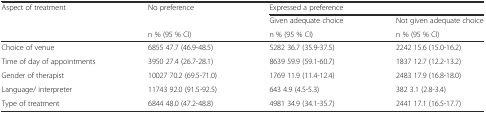

In [5]:
image

In [6]:
model = TabeleiroModel.from_pretrained("../../aux/models/model_3D-STEP_60000")

You are using a model of type dimbart to instantiate a model of type mbart. This is not supported for all configurations of models and can yield errors.


In [23]:
processor = TabeleiroProcessor.from_pretrained("../../aux/processors/donut-base")
processor.image_processor.size = model.encoder.config.image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
processor

TabeleiroProcessor:
- image_processor: DonutImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_thumbnail",
    "do_align_long_axis",
    "do_pad",
    "random_padding",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_align_long_axis": false,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "do_thumbnail": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DonutImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "DonutProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": [
    1200,
    900
  ]
}

- tokenizer: XLMRobertaTokenizerFast(name_or_path='../../aux/processors/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='rig

In [25]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<table_extraction>"])[0]
model.config

VisionEncoderDecoderConfig {
  "decoder": {
    "_name_or_path": "../../aux/models/model_3D-STEP_60000/dimbart_decoder",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "add_final_layer_norm": true,
    "architectures": [
      "DiMBartForCausalLM"
    ],
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": null,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 4,
    "decoder_start_token_id": null,
    "dim_max_position_embeddings": [
      514,
      120,
      120
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_attention_heads": 16,
    "encoder_ffn_dim": 4096,
    "encoder_layerdrop": 0.0,
    "encoder_layers

In [26]:
processor.decode(57527)

'<row>'

In [27]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class DonutTableDataset(Dataset):
    def __init__(
        self,
        annotations,
        max_length,
        ignore_id = -100,
        prompt_end_token = None,
    ):            
        self.annotations_files = list(annotations.keys())
        self.annotations = annotations
        
        self.max_length = max_length
        self.ignore_id = ignore_id        
        
        
    def __len__(self):
        return len(self.annotations)
    
    
    def __getitem__(self, idx):
        
        file_name = self.annotations_files[idx]
        
        gt = self.annotations[file_name]['html']
        
        image = Image.open(IMG_PATH + file_name)
        
        
        # inputs
        pixel_values = processor(image.convert("RGB"), random_padding=False, return_tensors="pt").pixel_values.squeeze()
        pixel_values = pixel_values.squeeze()
        
        encoding = dict(file_name = file_name,
                        pixel_values=pixel_values,
                        gt = gt)
        
        return encoding

In [28]:
import json
with open('../../aux/data/anns/test/final_eval.json') as fp:
    annotations = json.load(fp)

test_set = DonutTableDataset(annotations, 4096)

In [29]:
processor.decode(processor.tokenizer.eos_token_id)

'</s>'

In [30]:
sys.path.insert(1, '../../aux/PubTabNet/src/')
from metric import TEDS

teds = TEDS(n_jobs=4, structure_only = True, ignore_nodes = ["b"])

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [32]:
import torch
from tqdm.auto import tqdm

out_dics = {}
sum_score = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

decoder_input_ids = processor.tokenizer("<table_extraction>", add_special_tokens=False, return_tensors="pt").input_ids

for i, batch in enumerate(tqdm(train_dataloader)):
    
    pixel_values = batch["pixel_values"].to(device)
    filename = batch["file_name"][0]
    gt = batch['gt'][0].replace("> ", ">").replace(" <", "<")
    
    # autoregressively generate sequence
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids.to(device),
        max_length= 1600,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams= 3,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        )
    
    seq = torch.cat((outputs.sequences[0], torch.Tensor([2, 2]).int().to(device)), 0)
    print(filename)
    print(processor.decode(seq))
    table = processor.token2ann(seq, 1)
    
    table_html = "<html><body><table>" + processor.table2html(table['tables'][0]).replace("> ", ">").replace(" <", "<") + "</table></body></html>"
    
    
    score = teds.evaluate(table_html, gt)
    sum_score += score
    
    print(score,"--",sum_score/(i+1))
    
    out_dics[filename] = table_html

  0%|                                        | 1/9064 [00:00<1:32:43,  1.63it/s]

e87bba5267499998e22dc7e6b826adea9c0d3ff1a843f8ea24b55db5dea6fd86.png
<s><table_extraction><table><row><col_header> <b>Gene</b><col_header> <b>Primer sequence</b><row><cell> Collagen X<cell> Formal primer 5′-GCCCCTTCTGCTAGTGCTAGCTAGCT<row><cell> Reverse primer 5′ Reverse primer 5′</s></s></s>
0.0 -- 0.0


  0%|                                       | 2/9064 [00:09<13:23:17,  5.32s/it]

a52c0f276b273a14ad1a6b8424887106601733310cc62e7d326ad01ecfac1bd2.png
<s><table_extraction><table><row><col_header> <b>Studies</b><col_header> <b>Outcomes reported</b><col_header> <b>Types of participants<row><cell> Cavallasca 2008 [16]<cell> Stillbirth<cell> Stillbirth<cell> SLE versus<row><cell> SLE versus<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle<cell> Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle Sle

  0%|                                       | 3/9064 [00:18<17:27:51,  6.94s/it]

f2e33bdb03a47b2dc32664508679f2b2a7b313f5e2d096cbeb2be89614d7ceb6.png
<s><table_extraction><table><row><col_header><col_header> <b>Total</b><col_header> <b>Fixed-dose group</b><col_header><col_header> <b>Fixed-dose group</b><row><cell> January**<cell> 22.7<cell> 24.4<cell> 22.7<cell> 22.7<cell> 22.7<cell> 22.7<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 22.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 23.8<cell> 22.7 ± 2.5<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ± 1.0<cell> 23.6 ± 1.0<cell> 22.7 ± 1.0<cell> 22.7 ±

  0%|                                       | 4/9064 [00:26<19:10:19,  7.62s/it]

772b165aa6f4730bcf96b4ea4d16d34bef666bf22253825c1c351c25588991b0.png
<s><table_extraction><table><row><col_header><col_header> <b>No. herds</b><col_header> <b>End of one year study period</b><col_header> <b>Herd</b><col_header> <b>Herd</b> of year</b><col_header> <sup>Herd</b> of one year</b><row><cell> Herd</b><cell> Herd</b><row><cell><cell><cell><cell><cell><cell><cell><cell><cell><cell><cell><cell><cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45<cell> 45d</b><cell> 45d</b><cell> 45d</b><cell> 45d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</b>d</

  0%|                                       | 4/9064 [00:31<19:38:37,  7.81s/it]


KeyboardInterrupt: 

In [ ]:
prompt[:,0]

In [ ]:
cp_dic = out_dics.copy()

In [ ]:
out_dics = cp_dic.copy()
for filename in out_dics:
    out_dics[filename] = "<html><body><table>" + out_dics[filename] + "</table></body></html>"

In [ ]:
import json
with open("../../pubtabnet/TML_pred_dic-EPOCH1.json", 'w') as out:
    json.dump(out_dics, out, ensure_ascii=False)

In [ ]:
print(torch.cat((outputs.sequences[0], torch.tensor([processor.tokenizer.eos_token_id]).to(device)), 0))

In [ ]:
import json
with open("../../pubtabnet/final_eval.json", encoding="utf-8") as f:
    gts = json.load(f)

for gt in gts:
    if(gt == "663f4502ef940b47563185fb6dd16307b43b895fdb4fe1bbe8e514e6ad2bf6f2.png"):
        print(gts[gt]['html'].replace("<b>", "").replace("</b>", ""))

In [ ]:
del model

In [ ]:
processor